# Forecasting with an RNN

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

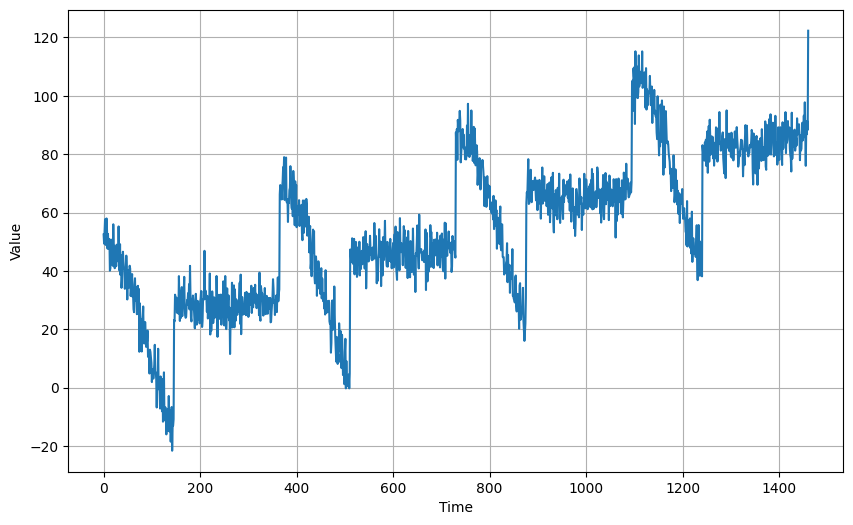

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN Forecasting

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 10s 905ms/step - loss: 58.7000 - mae: 59.1984 - val_loss: 12.2206 - val_mae: 12.7115
Epoch 2/500
8/8 [==============================] - 1s 50ms/step - loss: 22.0776 - mae: 22.5726 - val_loss: 28.5076 - val_mae: 29.0070
Epoch 3/500
8/8 [==============================] - 1s 49ms/step - loss: 11.8627 - mae: 12.3533 - val_loss: 20.1508 - val_mae: 20.6493
Epoch 4/500
8/8 [==============================] - 1s 49ms/step - loss: 9.8669 - mae: 10.3575 - val_loss: 20.9716 - val_mae: 21.4697
Epoch 5/500
8/8 [==============================] - 3s 416ms/step - loss: 9.8811 - mae: 10.3709 - val_loss: 11.6192 - val_mae: 12.1149
Epoch 6/500
8/8 [==============================] - 1s 104ms/step - loss: 8.2411 - mae: 8.7299 - val_loss: 14.3039 - val_mae: 14.8016
Epoch 7/500
8/8 [==============================] - 4s 548ms/step - loss: 8.5384 - mae: 9.0266 - val_loss: 10.4386 - val_mae: 10.9328
Epoch 8/500
8/8 [==============================] - 3s 469ms/ste

In [6]:
model = keras.models.load_model("my_checkpoint")

In [7]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 10ms/step


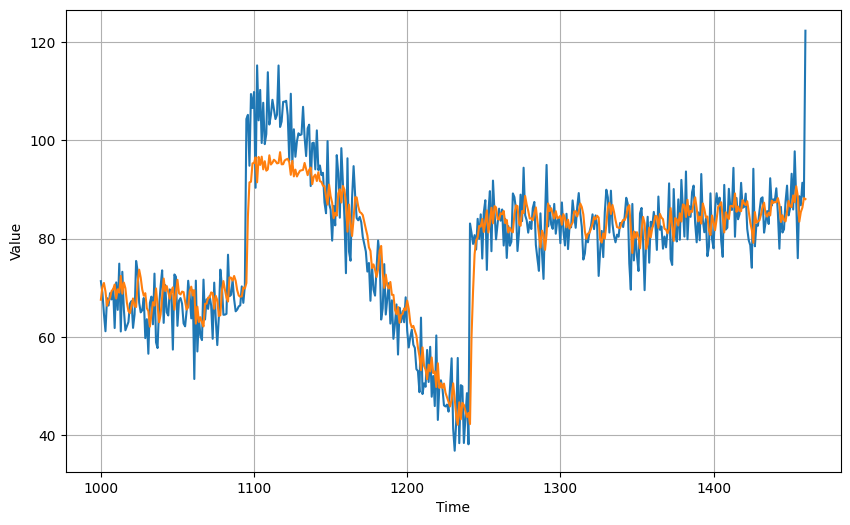

In [8]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [9]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.3660035

## Sequence-to-Sequence Forecasting

In [10]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [11]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]


In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 3s 112ms/step - loss: 160.7151 - mae: 161.2144 - val_loss: 158.3649 - val_mae: 158.8649
Epoch 2/500
8/8 [==============================] - 1s 53ms/step - loss: 78.3290 - mae: 78.8281 - val_loss: 16.4571 - val_mae: 16.9531
Epoch 3/500
8/8 [==============================] - 1s 53ms/step - loss: 31.3113 - mae: 31.8088 - val_loss: 13.9770 - val_mae: 14.4688
Epoch 4/500
8/8 [==============================] - 1s 103ms/step - loss: 20.7124 - mae: 21.2089 - val_loss: 10.1446 - val_mae: 10.6301
Epoch 5/500
8/8 [==============================] - 1s 106ms/step - loss: 13.6927 - mae: 14.1862 - val_loss: 23.9072 - val_mae: 24.4066
Epoch 6/500
8/8 [==============================] - 1s 88ms/step - loss: 10.6814 - mae: 11.1720 - val_loss: 13.1950 - val_mae: 13.6881
Epoch 7/500
8/8 [==============================] - 1s 56ms/step - loss: 8.0587 - mae: 8.5454 - val_loss: 14.5248 - val_mae: 15.0187
Epoch 8/500
8/8 [==============================] - 1s 58m

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 10ms/step


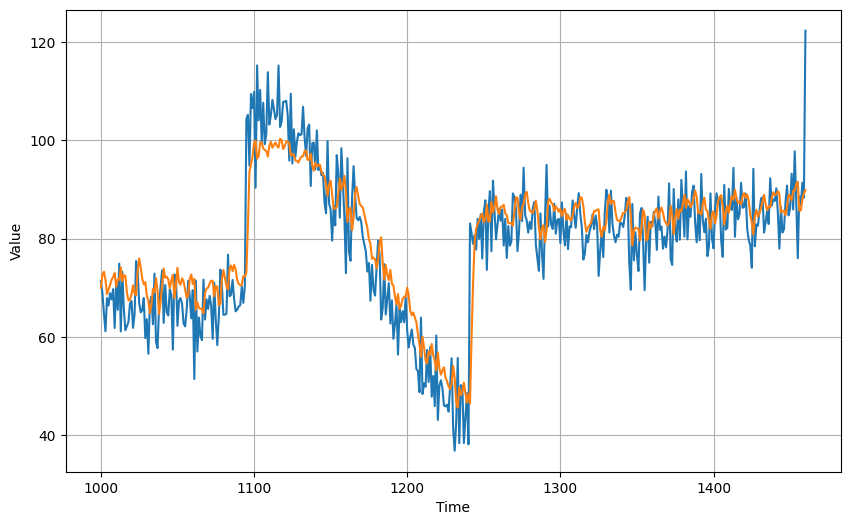

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.657539